In [5]:
import cv2
import h5py
import xraylib
import dxchange
import numpy as np
import tomocg as pt
import tifffile as tiff
import matplotlib.pyplot as plt 

In [6]:
def wavelength(energy):
    """Return the wavelength [cm] for a given energy [keV]."""
    return 2 * np.pi * PLANCK_CONSTANT * SPEED_OF_LIGHT / energy


def wavenumber(energy):
    """Return the wavenumber [1/cm] given energy [keV]."""
    return energy / PLANCK_CONSTANT / SPEED_OF_LIGHT


def exptomo(pixel_size, beta, energy):
    """ Exp representation of projections """
    return np.exp(-2 * wavenumber(energy) * pixel_size * beta)


def complex_refr_index(compound, energy, density):
    Re = xraylib.Refractive_Index_Re(compound = compound, E = energy, density = density)
    Im = xraylib.Refractive_Index_Im(compound = compound, E = energy, density = density)
    return (1 - Re, Im)


def sphere_mask(mesh_size, center, radius, dtype):
    X, Y, Z = np.ogrid[:mesh_size[0], :mesh_size[1], :mesh_size[2]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2, dtype = np.float32)
    mask = np.zeros(mesh_size, dtype = dtype)
    for r in range(len(radius)):
        mask_tmp = dist_from_center <= radius[r]
        mask += np.uint8(mask_tmp)     
    return mask


def radon_gpu (u0, n , nz, ntheta, center, theta, pnz, ngpus):
    with pt.SolverTomo(theta, ntheta, nz, n, pnz, center, ngpus) as slv:
            # generate data
            data = slv.fwd_tomo_batch(u0)
    return (data.real, data.imag)


def binning(data, level):
    data = tomopy.downsample(data, level=level, axis=2) 
    data = tomopy.downsample(data, level=level, axis=1)
    return data


def propagate_tie(beta, delta, energy, pixel_size, dist):
    """
    Propagate emitting x-ray wave based on Transport of Intensity.
    Parameters
    ----------
    beta : ndarray, optional
        3D tomographic data for real part .
    delta : ndarray
        3D tomographic data for refractive index.
    pixel_size : float
        Detector pixel size in cm.
    dist : float
        Propagation distance of the wavefront in cm.
    Returns
    -------
    ndarray
        3D propagated tomographic intensity.
    """
    i1 = exptomo(pixel_size = pixel_size , beta = beta, energy = energy)
    i2 = np.zeros(delta.shape)
    
    for m in range(delta.shape[0]):
        dx, dy = np.gradient(delta[m] * pixel_size, pixel_size)
        d2x, _ = np.gradient(i1[m] * dx, pixel_size)
        _, d2y = np.gradient(i1[m] * dy, pixel_size)
        i2[m] = i1[m] + dist * (d2x + d2y)
    return i2

## 1. Load data

In [4]:
# load artificial phantom
data = np.float32(tiff.imread('packing.tiff'))

# load real flat and dark data 
file_path = '/home/m_fokin/recon/exp2_raw/142_cell100bar_Sand10NaBr10.h5'
f = h5py.File(file_path, 'r')
flat = np.array(f['exchange']['data_white'], dtype = np.float32)
dark = np.array(f['exchange']['data_dark'], dtype = np.float32)
f.close()

In [8]:
# crop real data to artificial phantom shape 

size = 512
x0 = 500
y0 = 500

flat = flat[:, x0:x0 + size, y0:y0 + size]
dark = dark[:, x0:x0 + size, y0:y0 + size]

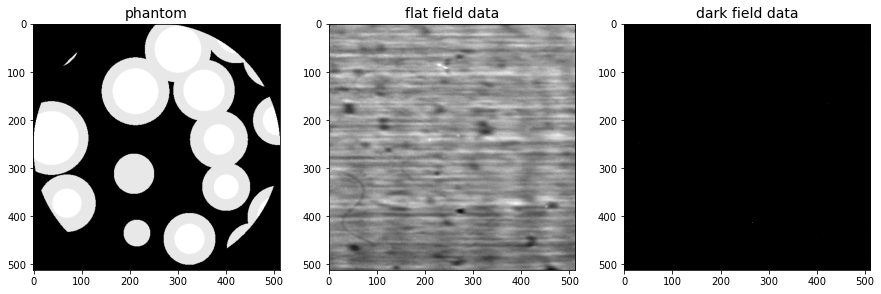

In [9]:
plt.figure(figsize = (15, 5))

plt.subplot(1,3,1)
plt.title("phantom", fontsize = '14')
plt.imshow(data[0], cmap = 'gray')

plt.subplot(1,3,2)
plt.title("flat field data", fontsize = '14')
plt.imshow(flat[0], cmap = 'gray')

plt.subplot(1,3,3)
plt.title("dark field data", fontsize = '14')
plt.imshow(dark[0], cmap = 'gray')

## 2. Set materials properties

In [12]:
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]
SPEED_OF_LIGHT = 299792458e+2  # [cm/s]

# sample size [px]
sample_size = data.shape

# center of sample rotation [px]
center = [sample_size[0] // 2, sample_size[1] // 2, sample_size[2] // 2]

# number of rotation angles
n_angles = int(sample_size[1] * (3/4))

# pixel size [cm]
pixel_size = 1e-4

# energy KeV
energy = 21 

In [13]:
# methane refractive index 
delta_m = complex_refr_index("CH4", energy, 0.00055)[0]
beta_m = complex_refr_index("CH4", energy, 0.00055)[1]

# quartz recractive index 
delta_c = complex_refr_index("SiO2", energy, 2.65)[0]
beta_c = complex_refr_index("SiO2",energy,2.65)[1]

# water refractive index
delta_w = complex_refr_index("H2O", energy, 1)[0]
beta_w = complex_refr_index("H2O", energy, 1)[1]

print("CH4 Refractive Index at 21.0 keV : {} - {} i".format(delta_m, beta_m))
print("SiO2 Refractive Index at 21.0 keV : {} - {} i".format(delta_c, beta_c))
print("H2O Refractive Index at 21.0 keV : {} - {} i".format(delta_w, beta_w))
                  
delta =  np.float32(tiff.imread('packing.tiff'))

beta =  np.float32(tiff.imread('packing.tiff'))

delta[np.where(delta == 0)] = delta_m
beta[np.where(beta == 0)] = beta_m

delta[np.where(delta == 10)] = delta_w
beta[np.where(beta == 10)] = beta_w

delta[np.where(delta == 11)] = delta_c
beta[np.where(beta == 11)] = beta_c

for i in range (delta.shape[0]):                
    delta[i,:,:] = cv2.GaussianBlur(delta[i,:,:],(7,7),0).astype(np.float32)
    beta[i,:,:] = cv2.GaussianBlur(beta[i,:,:],(7,7),0).astype(np.float32)

CH4 Refractive Index at 21.0 keV : 3.2266878058351267e-10 - 1.0248038879833976e-13 i
SiO2 Refractive Index at 21.0 keV : 1.2485900948711048e-06 - 2.7676264713571698e-09 i
H2O Refractive Index at 21.0 keV : 5.228090673714547e-07 - 3.407495879927353e-10 i


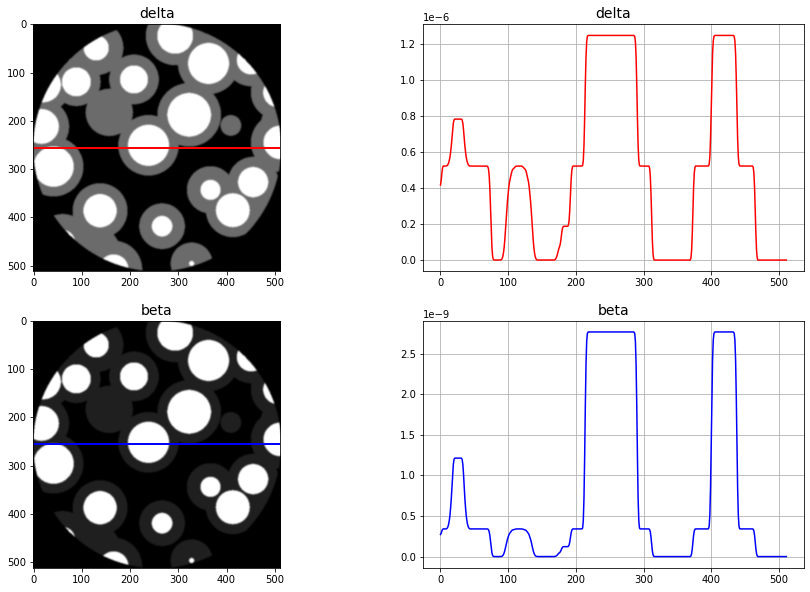

In [14]:
plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.title('delta', fontsize = '14')
plt.plot([0, sample_size[1]], [sample_size[2]//2, sample_size[2]//2], color="r", linewidth=2)
plt.imshow(delta[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(2,2,2)
plt.grid()
plt.title('delta', fontsize = '14')
plt.plot(delta[sample_size[0]//2,:,sample_size[2]//2], color="r")

plt.subplot(2,2,3)
plt.title('beta', fontsize = '14')
plt.plot([0, sample_size[1]], [sample_size[2]/2, sample_size[2]//2], color="b", linewidth=2)
plt.imshow(beta[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(2,2,4)
plt.grid()
plt.title('beta', fontsize = '14')
plt.plot(beta[sample_size[0]//2,:,sample_size[2]//2], color="b")

## 3. Make projections

In [16]:
n = sample_size[1]  # object size in x,y
nz = sample_size[0]  # object size in z
center = n/2  # rotation center

theta = np.linspace(0, np.pi, n_angles).astype('float32')  # angles

pnz = 1  # number of slice partitions for simultaneous processing in tomography
    
proj_delta = radon_gpu(delta + 1j*beta, n = n,
                      nz = nz, ntheta = n_angles, pnz = 1, center = center, 
                       theta = theta, ngpus = 1)[0]

proj_beta = radon_gpu(delta + 1j*beta, n = n,
                      nz = nz, ntheta = n_angles, pnz = 1, center = center, 
                       theta = theta, ngpus = 1)[1]

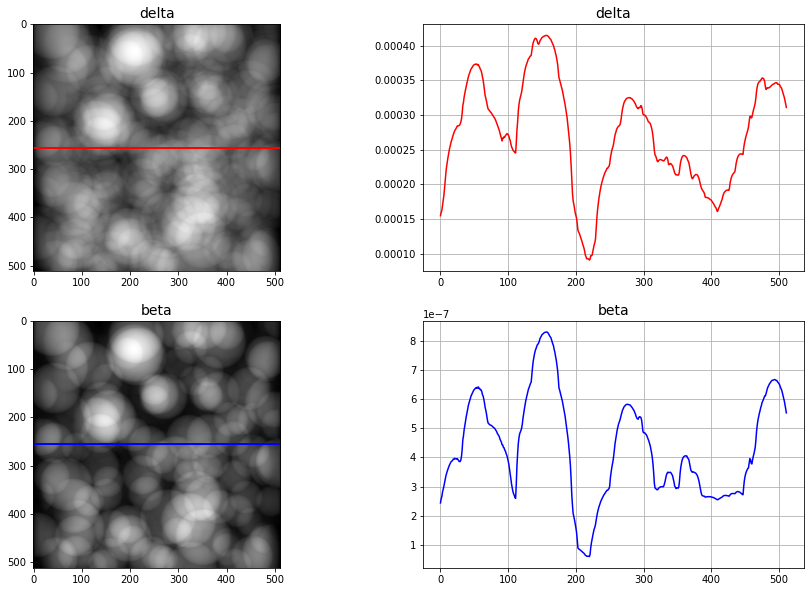

In [17]:
plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.title('delta', fontsize = '14')
plt.imshow(proj_delta[0,:,:], cmap = 'gray')

plt.subplot(2,2,2)
plt.grid()
plt.title('delta', fontsize = '14')
plt.plot(proj_delta[0,:,sample_size[0]//2], color="r")


plt.subplot(2,2,3)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="b", linewidth=2)
plt.title('beta', fontsize = '14')
plt.imshow(proj_beta[0,:,:], cmap = 'gray')

plt.subplot(2,2,4)
plt.grid()
plt.title('beta', fontsize = '14')
plt.plot(proj_beta[0,:,sample_size[0]//2], color="b")

## 4. Add phase artefacts by solving TIE 

In [26]:
proj_tie = propagate_tie(beta = proj_beta, delta = proj_delta, energy = 21, pixel_size = pixel_size, dist = 10)

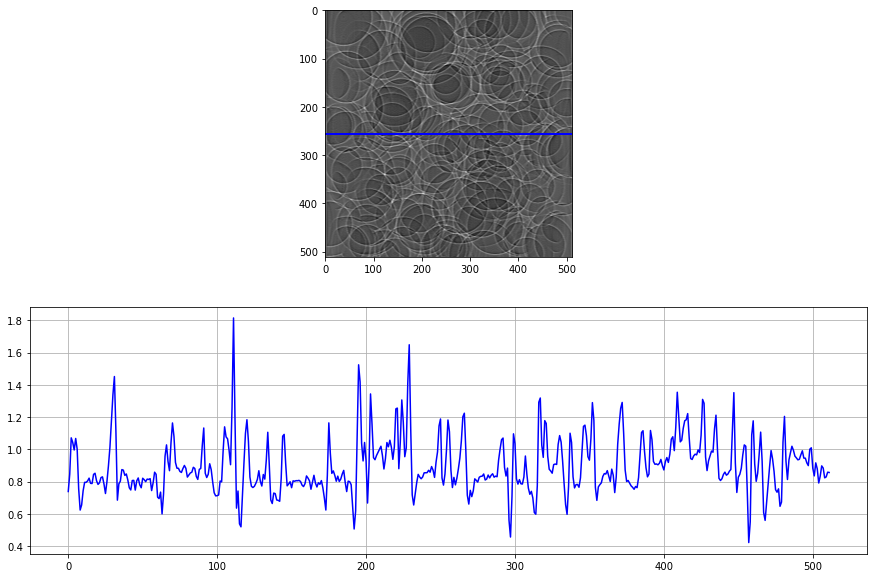

In [27]:
plt.figure(figsize = (15, 10))

plt.subplot(2,1,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="b", linewidth=2)
plt.imshow(proj_tie[0,:,:], cmap = 'gray')

plt.subplot(2,1,2)
plt.grid()
plt.plot(proj_tie[0,:,sample_size[0]//2], color="b")

## 5. Add real noise to the projection

In [28]:
N = 0 
proj_tie = proj_tie * (flat[N] - dark[N]) + dark[N]

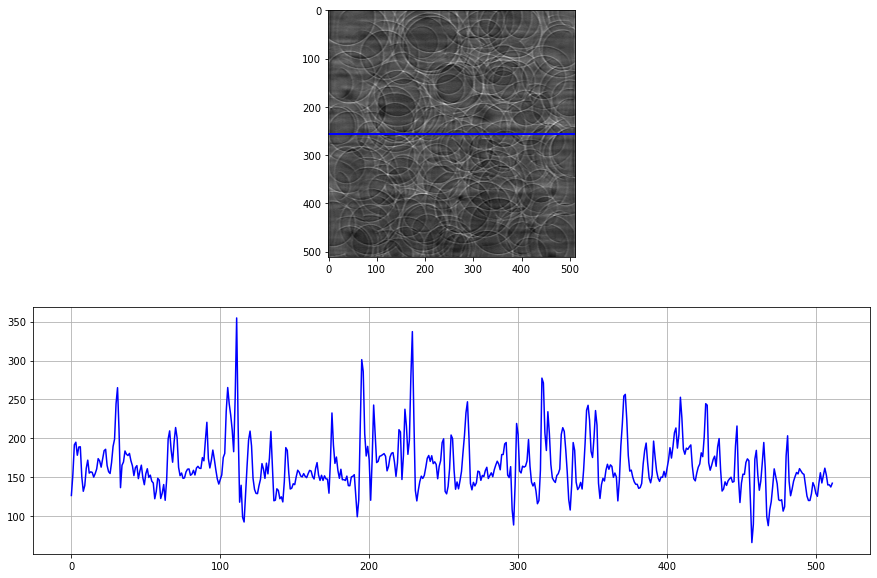

In [32]:
plt.figure(figsize = (15, 10))

plt.subplot(2,1,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="b", linewidth=2)
plt.imshow(proj_tie[0,:,:], cmap = 'gray')

plt.subplot(2,1,2)
plt.grid()
plt.plot(proj_tie[0,:,sample_size[0]//2], color="b")

## 6. Write h5 file

In [34]:
theta = np.linspace(0, 180, n_angles).astype('float32')

dxchange.writer.write_hdf5(data = proj_tie, fname='data.h5', gname='exchange', dname='data', dtype=np.float32, appendaxis = 0)
dxchange.writer.write_hdf5(data = flat, fname='data.h5', gname='exchange', dname='data_white', dtype=np.float32, appendaxis = 0)
dxchange.writer.write_hdf5(data = dark, fname='data.h5', gname='exchange', dname='data_dark', dtype=np.float32, appendaxis = 0)
dxchange.writer.write_hdf5(data = theta, fname='data.h5', gname='exchange', dname='theta', dtype=np.float32, appendaxis = 0)